In [1]:
# Load data function
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
%matplotlib inline
def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    min_max_scaler = preprocessing.MinMaxScaler()
    images = min_max_scaler.fit_transform(images)

    return images, labels

## Load datdaset

In [57]:
# # Load ORL dataset.
# X, Y = load_data(root='data/ORL', reduce=2)
# print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
# X, Y = load_data(root='data/CroppedYaleB', reduce=4)
# print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# ORL
img_size = [i//3 for i in (92, 112)] # ORL
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)


/Users/chenquan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Add gaussian and crop noise

In [58]:
def add_gaussian_noise(V,mu,sigma,percentage):
    '''
    V is (m,n)
    percentage is [0.05,1]
    
    Return: noise (m,n)
    '''
    n = V.shape[1]
    m = V.shape[0]
    noise = np.zeros((m,n))
    num_pixel = int(n*percentage)
    for i in range(m):
        pixel = np.random.choice(range(n), num_pixel)
        noise[i,pixel] = noise[i,pixel] + np.random.normal(mu,sigma,num_pixel)
    return noise 
  
# Add crop noise function 
def add_crop_noise(V,img_size,percentage):
    '''
    V is (m,n)
    row, col: how many row and 
    
    Return: noise (m,n)
    '''
    V_croped = V.copy().T
    n = V.shape[0]
    m = V.shape[1]
    block_size = int(np.sqrt(n*percentage))
    
    for img in range(m):
        point_row = int(np.random.uniform(0,img_size[1]-block_size))
        point_col = int(np.random.uniform(0,img_size[0]-block_size))
        for row in range(point_row,point_row+block_size):
            for col in range(point_col,point_col+block_size):
                V_croped[img].reshape(img_size[1],img_size[0])[row][col] = 0
    return V_croped.T

## Test the noise

In [59]:
def plot_Gaussian_noise(V_hat,V_noise,V,img_size,ind):
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Original)')
    plt.subplot(132)
    plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Noise')
    plt.subplot(133)
    plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Noise)')
    plt.show()
    
def plot_Crop_noise(V_hat,V,img_size,ind):
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Original)')
    plt.subplot(122)
    plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Noise)')
    plt.show()
    
def plot_NMF_after_Gaussian_noise(V_hat,V_noise,V,W,H,img_size,ind):
    plt.figure(figsize=(10,3))
    plt.subplot(141)
    plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Original)')
    plt.subplot(142)
    plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Noise')
    plt.subplot(143)
    plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Noise)')
    plt.subplot(144)
    plt.imshow(W.dot(H)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('After NMF')
    plt.show()

def plot_NMF_after_Crop_noise(V_hat,V,W,H,img_size,ind):
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Original)')
    plt.subplot(132)
    plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Noise)')
    plt.subplot(133)
    plt.imshow(W.dot(H)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('After NMF')
    plt.show()

#### Test  gaussian noise

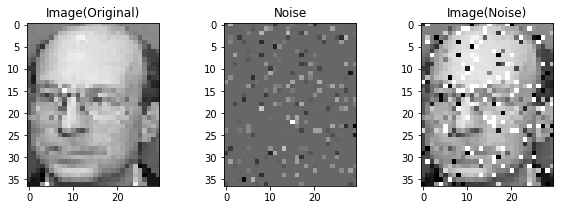

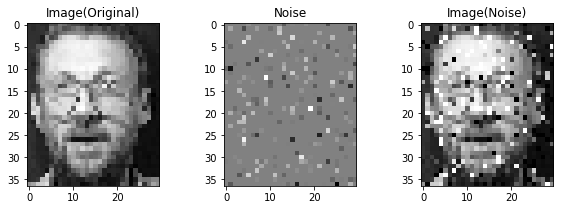

In [60]:
# Test the gaussian noise
ind =40
V_noise = add_gaussian_noise(V_hat,0.2,0.7,0.2)
V = V_hat + V_noise
V[V<0] = 0
V[V>1] = 1
plot_Gaussian_noise(V_hat,V_noise,V,img_size,ind)

ind =50
plot_Gaussian_noise(V_hat,V_noise,V,img_size,ind)

#### Test  crop noise

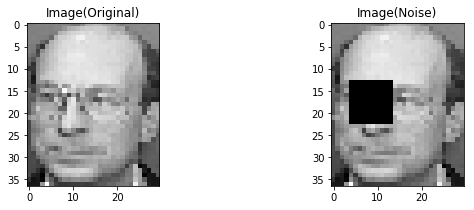

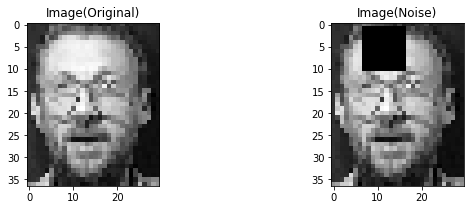

In [61]:
# Test the crop noise
ind =40
V = add_crop_noise(V_hat,img_size,0.1)
plot_Crop_noise(V_hat,V,img_size,ind)
ind =50
plot_Crop_noise(V_hat,V,img_size,ind)

## Update methods 

### 1. Original NMF, multiplicative update rule(MUR)

\begin{equation}
\mathbf{P}_{ij} = \mathbf{P}_{ij} \frac{(\mathbf{R}\mathbf{Q})_{ij}}{(\mathbf{P}\mathbf{Q}^T\mathbf{Q})_{ij}}
\end{equation}
\begin{equation}
\mathbf{Q}^T_{ij} = \mathbf{Q}^T_{ij} \frac{(\mathbf{P}^T\mathbf{R})_{ij}}{(\mathbf{P}^T\mathbf{P}\mathbf{Q}^T)_{ij}}
\end{equation}

In [62]:
def mf_multiplicative_update(R, P, Q, steps=5000):
    for step in range(steps):
        Pu = P*(R.dot(Q.T))/(P.dot(Q).dot(Q.T))
        Qu = Q*(Pu.T@R/(Pu.T@Pu@Q))
        e_P = np.sqrt(np.sum((Pu-P)**2, axis=(0,1)))/P.size
        e_Q = np.sqrt(np.sum((Qu-Q)**2, axis=(0,1)))/Q.size
        if e_P<1e-5 and e_Q<1e-5:
            break
        P = Pu
        Q = Qu
    return P, Q

### 2. L21 NMF
Iteratively updating algorithm

\begin{equation}
\mathbf{F}_{jkj} = \mathbf{F}_{jk} \frac{(\mathbf{X}\mathbf{D}\mathbf{G}^T)_{jk}}{(\mathbf{F}\mathbf{G}\mathbf{D}\mathbf{G}^T)_{jk}}
\end{equation}
\begin{equation}
\mathbf{G}_{ki} = \mathbf{G}_{ki} \frac{(\mathbf{F}^T\mathbf{X}\mathbf{D})_{ki}}{(\mathbf{F}^T\mathbf{F}\mathbf{G}\mathbf{D})_{ki}}
\end{equation}



where D is diagonal matrix with the diagonal elements given by\begin{equation}
\mathbf{D}_{ii} = \frac{1}{\sqrt{\sum_{j=1}^{p} (\mathbf{X}-\mathbf{F}\mathbf{G})^2_{ji}}} =\frac{1}{|| x_i-Fg_i||}
\end{equation}

In [108]:
# def mf_L21_multiplicative_update(X, F, G, steps=5000):
#     D = 0
#     for step in range(steps):
#         Dii = (1/np.sqrt(np.sum((X - F.dot(G))**2, axis = 0)))
#         D = np.diag(Dii)
#         Fu = F*(X.dot(D).dot(G.T))/(F.dot(G).dot(D).dot(G.T))
#         Gu = G*(Fu.T.dot(X).dot(D))/(Fu.T.dot(Fu).dot(G).dot(D))

#         e_F = np.sqrt(np.sum((Fu-F)**2, axis=(0,1)))/F.size
#         e_G = np.sqrt(np.sum((Gu-G)**2, axis=(0,1)))/G.size
#         if e_F<1e-5 and e_G<1e-5:
#             break
#         F = Fu
#         G = Gu
#     return F,G

def mf_L21_multiplicative_update(X, F, G, steps=5000):
    for step in range(steps):
        Dii = (1/np.sqrt(np.sum((X - F.dot(G))**2, axis = 0)))
        D = np.diag(Dii)
        Fu = F*(X.dot(D).dot(G.T))/(F.dot(G).dot(D).dot(G.T))
        Gu = G*(Fu.T.dot(X).dot(D))/(Fu.T.dot(Fu).dot(G).dot(D))

        e_F = np.sqrt(np.sum((Fu-F)**2, axis=(0,1)))/F.size
        e_G = np.sqrt(np.sum((Gu-G)**2, axis=(0,1)))/G.size
        if e_F<1e-5 and e_G<1e-5:
            break
        F = Fu
        G = Gu
    return F,G

# L1

In [64]:
# L1
def mf_L1_multiplicative_update(X, F, G, steps=5000):
    eta = 0.1
    for step in range(steps):
        W = 1/(np.sqrt((X-F.dot(G))**2+eta**2))
        a = np.multiply(X,W).dot(G.T)

        Fu = F*(np.multiply(X,W).dot(G.T))/( np.multiply(F.dot(G),W).dot(G.T))

        Gu = G*(Fu.T.dot(np.multiply(X,W)))/(Fu.T.dot( np.multiply(Fu.dot(G), W) ))

        e_F = np.sqrt(np.sum((Fu-F)**2, axis=(0,1)))/F.size
        e_G = np.sqrt(np.sum((Gu-G)**2, axis=(0,1)))/G.size
        
        if e_F<1e-5 and e_G<1e-5:
            break
        F = Fu
        G = Gu
    return F,G

## Implementing two rules

In [65]:
steps = 500

#### 1. Use standar multiplicative update methods on ORL

##### 1.1 Gaussian noise

In [66]:
# Add Noise.
V_noise = add_gaussian_noise(V_hat,0.2,0.7,0.1)
V = V_hat + V_noise
V[V<0] = 0
V[V>1] = 1
# img_size = [i//4 for i in (168, 192)] # CroppedYaleB
print('==> Apply NMF ...')

N = V.shape[0]
M = V.shape[1]
K = len(set(Y_hat))
rng = np.random.RandomState(1)

F = rng.rand(N,K)
G = rng.rand(K,M)
W,H = mf_multiplicative_update(V,F,G,steps=steps)

==> Apply NMF ...


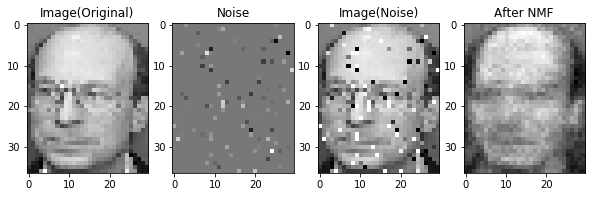

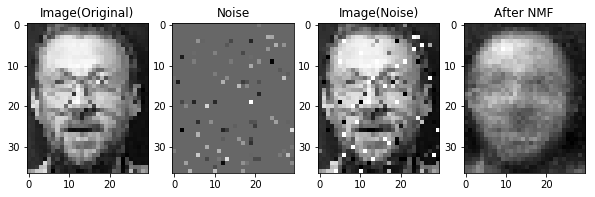

In [67]:
ind = 40 # index of demo image.
plot_NMF_after_Gaussian_noise(V_hat,V_noise,V,W,H,img_size,ind)
ind = 50 # index of demo image.
plot_NMF_after_Gaussian_noise(V_hat,V_noise,V,W,H,img_size,ind)

##### 1.2 Crop noise

In [68]:
# Add Noise.
V = add_crop_noise(V_hat,img_size,0.1)
V[V<0] = 0
V[V>255] = 255
# img_size = [i//4 for i in (168, 192)] # CroppedYaleB
print('==> Apply NMF ...')

N = V.shape[0]
M = V.shape[1]
K = len(set(Y_hat))
rng = np.random.RandomState(1)

F = rng.rand(N,K)
G = rng.rand(K,M)
W,H = mf_multiplicative_update(V,F,G,steps=steps)

==> Apply NMF ...


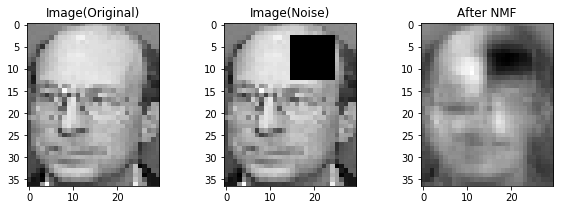

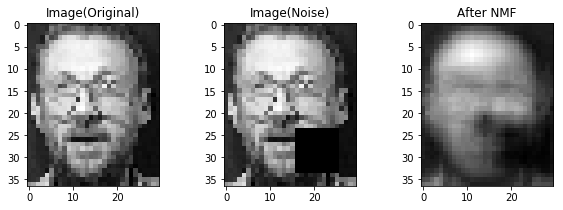

In [69]:
ind = 40 # index of demo image.
plot_NMF_after_Crop_noise(V_hat,V,W,H,img_size,ind)
ind = 50 # index of demo image.
plot_NMF_after_Crop_noise(V_hat,V,W,H,img_size,ind)

#### 2. Use mf_L21_multiplicative_update

#### 2.1 Gaussian noise

In [70]:
# Add Noise.
V_noise = add_gaussian_noise(V_hat,0.2,0.7,0.1)
V = V_hat + V_noise
V[V<0] = 0
V[V>1] = 1
# img_size = [i//4 for i in (168, 192)] # CroppedYaleB

print('==> Apply NMF ...')
N = V.shape[0]
M = V.shape[1]
K = len(set(Y_hat))
rng = np.random.RandomState(1)

F = rng.rand(N,K)
G = rng.rand(K,M)
W,H = mf_L21_multiplicative_update(V,F,G,steps=steps)

==> Apply NMF ...


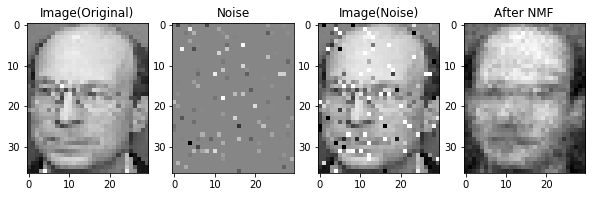

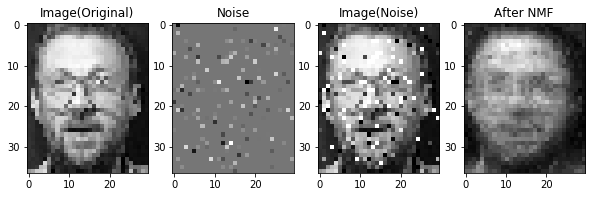

In [71]:
ind = 40 # index of demo image.
plot_NMF_after_Gaussian_noise(V_hat,V_noise,V,W,H,img_size,ind)
ind = 50 # index of demo image.
plot_NMF_after_Gaussian_noise(V_hat,V_noise,V,W,H,img_size,ind)

#### 2.2 Crop noise

In [72]:
# Add Noise.
V = add_crop_noise(V_hat,img_size,0.1)
V[V<0] = 0
V[V>255] = 255
# img_size = [i//4 for i in (168, 192)] # CroppedYaleB
print('==> Apply NMF ...')

N = V.shape[0]
M = V.shape[1]
K = len(set(Y_hat))
rng = np.random.RandomState(1)

F = rng.rand(N,K)
G = rng.rand(K,M)
W,H = mf_L21_multiplicative_update(V,F,G,steps=steps)

==> Apply NMF ...


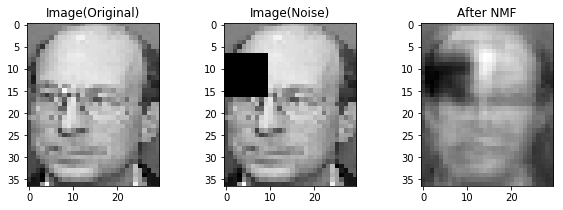

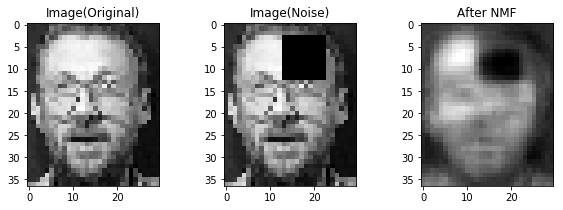

In [73]:
ind = 40 # index of demo image.
plot_NMF_after_Crop_noise(V_hat,V,W,H,img_size,ind)
ind = 50 # index of demo image.
plot_NMF_after_Crop_noise(V_hat,V,W,H,img_size,ind)

# Evaluation methods
## 1. Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}

In [74]:
# Used for calculate error cahce for iteration 
def RRE(V,W,H):
    RRE = np.linalg.norm(V - W.dot(H)) / np.linalg.norm(V)
    return RRE

## 2. Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [75]:
# Used for NMI cache cahce for iteration
def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

def NMI(Y_hat, Y_pred):
    return normalized_mutual_info_score(Y_hat, Y_pred)

In [76]:
# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)
acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))

Acc(NMI) = 0.3125 (0.4805)


# Data pre-processing 
Do data pre-processing before doing NFM and feed KNN model.

In [77]:
def pre_processing(V):
    min_max_scaler = preprocessing.MinMaxScaler()
    return min_max_scaler.fit_transform(V.T).T

# Different percentage of noise's effect on different NMF methods 

In [1]:
def evaluate(V_hat,img_size,NMF,add_noise,noise_percentage,NMF_type):
    total_image = V_hat.shape[1]
    a = np.arange(total_image)
    np.random.shuffle(a)
    a = a[0:int(0.9*total_image)]
    
    V_hat = V_hat[:,a]
    selected_Y_hat = Y_hat[a]
    if add_noise == add_crop_noise:
        for percentage in noise_percentage:
            # Add Noise.
            V = add_noise(V_hat,img_size,percentage)

            # img_size = [i//4 for i in (168, 192)] # CroppedYaleB
            N = V.shape[0]
            M = V.shape[1]
            K = len(set(selected_Y_hat))
            rng = np.random.RandomState(1)
            F = rng.rand(N,K)
            G = rng.rand(K,M)
            W,H = NMF(V,F,G,steps=steps)
            Y_pred = assign_cluster_label(H.T, selected_Y_hat)
            acc = accuracy_score(selected_Y_hat, Y_pred)
            nmi = normalized_mutual_info_score(selected_Y_hat, Y_pred)
            
            if NMF_type == 'Original':           
                original_crop_noise_acc_cache.append(acc)
                original_crop_noise_nmi_cache.append(nmi)
                original_crop_noise_error_cache.append(RRE(V_hat,W,H))
            elif NMF_type == 'L1':
                L1_crop_noise_acc_cache.append(acc)
                L1_crop_noise_nmi_cache.append(nmi)
                L1_crop_noise_error_cache.append(RRE(V_hat,W,H))
            elif NMF_type == 'L21':
                L21_crop_noise_acc_cache.append(acc)
                L21_crop_noise_nmi_cache.append(nmi)
                L21_crop_noise_error_cache.append(RRE(V_hat,W,H))
    elif add_noise == add_gaussian_noise:
        for percentage in noise_percentage:
            # Add Noise.
            V_noise = 0
            V = 0
            V_noise = add_noise(V_hat,0.3,0.7,percentage)
            V = V_hat + V_noise
            V[V<0] = 0
            V[V>1] = 1
            # img_size = [i//4 for i in (168, 192)] # CroppedYaleB
            N = V.shape[0]
            M = V.shape[1]
            K = len(set(selected_Y_hat))
            rng = np.random.RandomState(1)
            F = rng.rand(N,K)
            G = rng.rand(K,M)

            # Data pre-processing 
#             V = pre_processing(V)

            W,H = NMF(V,F,G,steps=steps)
            Y_pred = assign_cluster_label(H.T, selected_Y_hat)

            acc = accuracy_score(selected_Y_hat, Y_pred)
            nmi = normalized_mutual_info_score(selected_Y_hat, Y_pred)
            if NMF_type == 'Original':           
                original_gaussian_noise_acc_cache.append(acc)
                original_gaussian_noise_nmi_cache.append(nmi)
                original_gaussian_noise_error_cache.append(RRE(V_hat,W,H))
            elif NMF_type == 'L1':
                L1_gaussian_noise_acc_cache.append(acc)
                L1_gaussian_noise_nmi_cache.append(nmi)
                L1_gaussian_noise_error_cache.append(RRE(V_hat,W,H))
            elif NMF_type == 'L21':
                L21_gaussian_noise_acc_cache.append(acc)
                L21_gaussian_noise_nmi_cache.append(nmi)
                L21_gaussian_noise_error_cache.append(RRE(V_hat,W,H))
    else: print("Wrong adding noise method")

## 1. Gaussian noise

In [120]:
###############################################
# Different percentage of Gaussian noise cache 
###############################################
'''Gaussian noise from 5% to 60%'''
# Traditional NMF 
gaussian_noise_percentage = np.linspace(0,1,10)
original_gaussian_noise_error_cache = []
original_gaussian_noise_acc_cache = []
original_gaussian_noise_nmi_cache = []
L1_gaussian_noise_error_cache = []
L1_gaussian_noise_acc_cache = []
L1_gaussian_noise_nmi_cache = []
L21_gaussian_noise_error_cache = []
L21_gaussian_noise_acc_cache = []
L21_gaussian_noise_nmi_cache = []

evaluate(V_hat,img_size,mf_multiplicative_update,add_gaussian_noise,gaussian_noise_percentage,'Original')
evaluate(V_hat,img_size,mf_L1_multiplicative_update,add_gaussian_noise,gaussian_noise_percentage,'L1')
evaluate(V_hat,img_size,mf_L21_multiplicative_update,add_gaussian_noise,gaussian_noise_percentage,'L21')

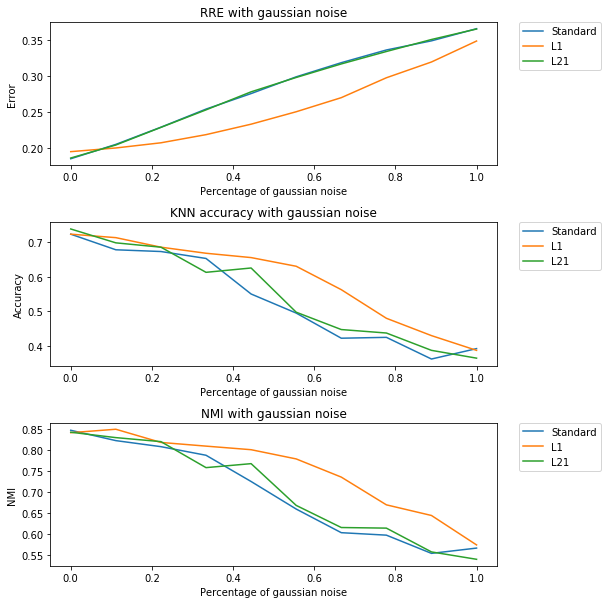

In [121]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(gaussian_noise_percentage,original_gaussian_noise_error_cache,label = 'Standard')
plt.plot(gaussian_noise_percentage,L1_gaussian_noise_error_cache,label = 'L1');
plt.plot(gaussian_noise_percentage,L21_gaussian_noise_error_cache,label = 'L21')
plt.title('RRE with gaussian noise')
plt.ylabel('Error')
plt.xlabel('Percentage of gaussian noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplot(312)
plt.plot(gaussian_noise_percentage,original_gaussian_noise_acc_cache,label='Standard');
plt.plot(gaussian_noise_percentage,L1_gaussian_noise_acc_cache,label = 'L1');
plt.plot(gaussian_noise_percentage,L21_gaussian_noise_acc_cache,label = 'L21');
plt.title('KNN accuracy with gaussian noise')
plt.ylabel('Accuracy')
plt.xlabel('Percentage of gaussian noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplot(313)
plt.plot(gaussian_noise_percentage,original_gaussian_noise_nmi_cache,label='Standard');
plt.plot(gaussian_noise_percentage,L1_gaussian_noise_nmi_cache,label = 'L1');
plt.plot(gaussian_noise_percentage,L21_gaussian_noise_nmi_cache,label = 'L21');
plt.title('NMI with gaussian noise')
plt.ylabel('NMI')
plt.xlabel('Percentage of gaussian noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplots_adjust(wspace =0, hspace =0.4)

In [81]:
L21_gaussian_noise_error_cache

[0.1856621261474822,
 0.2041947078978107,
 0.22863292822032147,
 0.2539275491885376,
 0.2768536850505413,
 0.29779312948529446,
 0.31830539572156286,
 0.3352635537998806,
 0.3510826978918117,
 0.36399719337819836]

In [82]:
original_gaussian_noise_error_cache

[0.18462555854199317,
 0.20387057267590258,
 0.22865477713817323,
 0.2536686602782348,
 0.27727794349233037,
 0.2985052104196155,
 0.31764852026233725,
 0.33567833967439503,
 0.35106844931539594,
 0.365749960597132]

## 2. Crop noise

In [83]:
###############################################
# Different percentage of Crop noise cache 
###############################################
'''Crop noise from 1% to 15%'''
# Traditional NMF 
crop_noise_percentage = np.linspace(0,0.25,10)
original_crop_noise_error_cache = []
original_crop_noise_acc_cache = []
original_crop_noise_nmi_cache = []

L1_crop_noise_error_cache = []
L1_crop_noise_acc_cache = []
L1_crop_noise_nmi_cache = []

L21_crop_noise_error_cache = []
L21_crop_noise_acc_cache = []
L21_crop_noise_nmi_cache = []

        
evaluate(V_hat,img_size,mf_multiplicative_update,add_crop_noise,crop_noise_percentage,'Original')
evaluate(V_hat,img_size,mf_L1_multiplicative_update,add_crop_noise,crop_noise_percentage,'L1')
evaluate(V_hat,img_size,mf_L21_multiplicative_update,add_crop_noise,crop_noise_percentage,'L21')

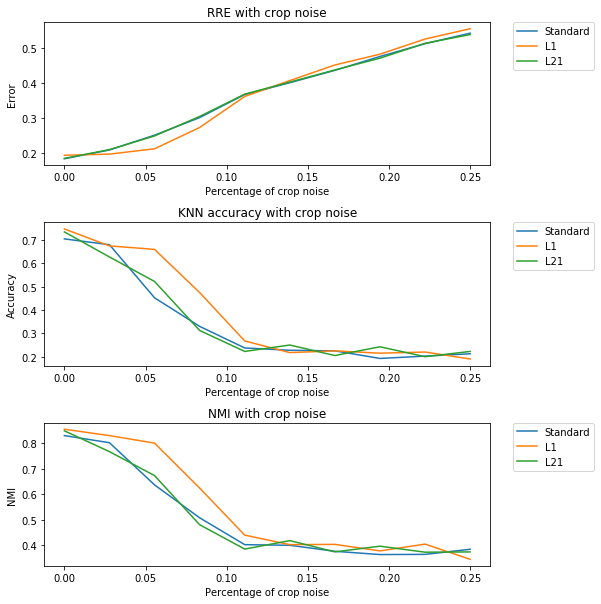

In [85]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(crop_noise_percentage,original_crop_noise_error_cache,label = 'Standard')
plt.plot(crop_noise_percentage,L1_crop_noise_error_cache,label = 'L1');
plt.plot(crop_noise_percentage,L21_crop_noise_error_cache,label = 'L21')
plt.title('RRE with crop noise')
plt.ylabel('Error')
plt.xlabel('Percentage of crop noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplot(312)
plt.plot(crop_noise_percentage,original_crop_noise_acc_cache,label='Standard');
plt.plot(crop_noise_percentage,L1_crop_noise_acc_cache,label = 'L1');
plt.plot(crop_noise_percentage,L21_crop_noise_acc_cache,label = 'L21');
plt.title('KNN accuracy with crop noise')
plt.ylabel('Accuracy')
plt.xlabel('Percentage of crop noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplot(313)
plt.plot(crop_noise_percentage,original_crop_noise_nmi_cache,label='Standard');
plt.plot(crop_noise_percentage,L1_crop_noise_nmi_cache,label = 'L1');
plt.plot(crop_noise_percentage,L21_crop_noise_nmi_cache,label = 'L21');
plt.title('NMI with crop noise')
plt.ylabel('NMI')
plt.xlabel('Percentage of crop noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplots_adjust(wspace =0, hspace =0.4)

# CroppedYaleB Data

In [48]:
# Load Extended YaleB dataset.
V_hat, Y_hat = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))
img_size = [i//4 for i in (168, 192)] # CroppedYaleB

Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


/Users/chenquan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### Test Gaussian noise

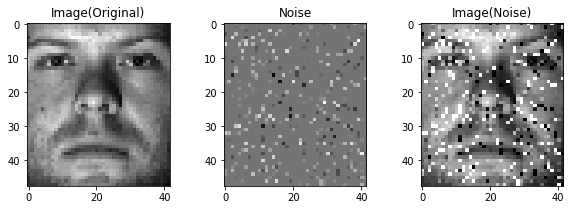

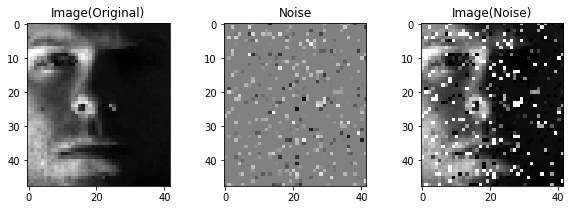

In [51]:
# Test the gaussian noise
ind =40
V_noise = add_gaussian_noise(V_hat,0.2,0.7,0.2)
V = V_hat + V_noise
V[V<0] = 0
V[V>1] = 1
plot_Gaussian_noise(V_hat,V_noise,V,img_size,ind)

ind =50
plot_Gaussian_noise(V_hat,V_noise,V,img_size,ind)

###  Test crop noise

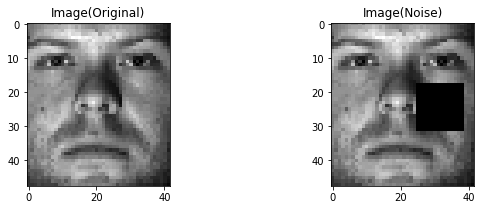

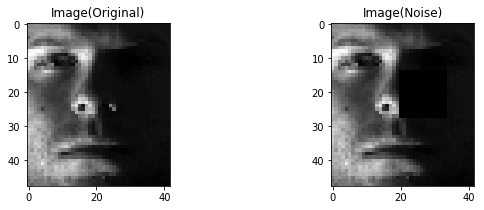

In [52]:
# Test the crop noise
ind =40
V = add_crop_noise(V_hat,img_size,0.1)
plot_Crop_noise(V_hat,V,img_size,ind)
ind =50
plot_Crop_noise(V_hat,V,img_size,ind)

In [54]:
###############################################
# Different percentage of Gaussian noise cache 
###############################################
'''Gaussian noise from 0% to 100%'''
# Traditional NMF 
gaussian_noise_percentage = np.linspace(0,1,10)
original_gaussian_noise_error_cache = []
original_gaussian_noise_acc_cache = []
original_gaussian_noise_nmi_cache = []
L1_gaussian_noise_error_cache = []
L1_gaussian_noise_acc_cache = []
L1_gaussian_noise_nmi_cache = []
L21_gaussian_noise_error_cache = []
L21_gaussian_noise_acc_cache = []
L21_gaussian_noise_nmi_cache = []

evaluate(V_hat,img_size,mf_multiplicative_update,add_gaussian_noise,gaussian_noise_percentage,'Original')
evaluate(V_hat,img_size,mf_L1_multiplicative_update,add_gaussian_noise,gaussian_noise_percentage,'L1')
evaluate(V_hat,img_size,mf_L21_multiplicative_update,add_gaussian_noise,gaussian_noise_percentage,'L21')

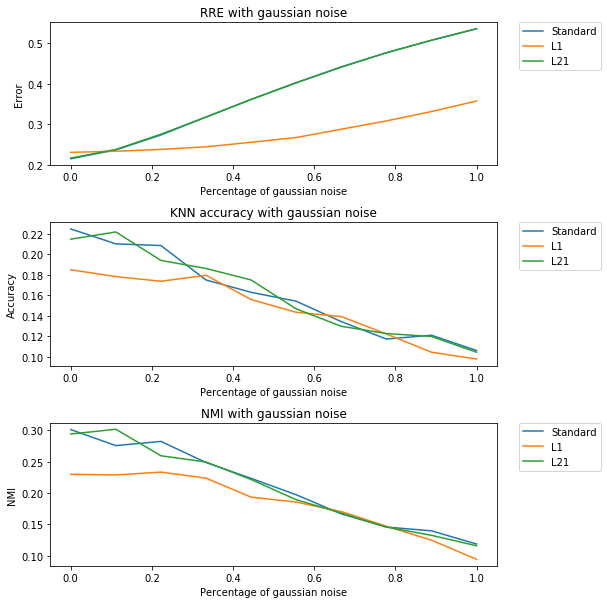

In [55]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(gaussian_noise_percentage,original_gaussian_noise_error_cache,label = 'Standard')
plt.plot(gaussian_noise_percentage,L1_gaussian_noise_error_cache,label = 'L1');
plt.plot(gaussian_noise_percentage,L21_gaussian_noise_error_cache,label = 'L21')
plt.title('RRE with gaussian noise')
plt.ylabel('Error')
plt.xlabel('Percentage of gaussian noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplot(312)
plt.plot(gaussian_noise_percentage,original_gaussian_noise_acc_cache,label='Standard');
plt.plot(gaussian_noise_percentage,L1_gaussian_noise_acc_cache,label = 'L1');
plt.plot(gaussian_noise_percentage,L21_gaussian_noise_acc_cache,label = 'L21');
plt.title('KNN accuracy with gaussian noise')
plt.ylabel('Accuracy')
plt.xlabel('Percentage of gaussian noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplot(313)
plt.plot(gaussian_noise_percentage,original_gaussian_noise_nmi_cache,label='Standard');
plt.plot(gaussian_noise_percentage,L1_gaussian_noise_nmi_cache,label = 'L1');
plt.plot(gaussian_noise_percentage,L21_gaussian_noise_nmi_cache,label = 'L21');
plt.title('NMI with gaussian noise')
plt.ylabel('NMI')
plt.xlabel('Percentage of gaussian noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.subplots_adjust(wspace =0, hspace =0.4)

In [3]:
import numpy as np
a = np.array([[1,2]])
b = np.array([[3,4]])

In [4]:
a+b

array([[4, 6]])